# Gotta Classify 'Em All 

We'll create and train a model that classifies Gen1 Pokemon using PyTorch and a pretrained Inception v3 model (although you are free to define your own architecture). 

[Here's where you can find the dataset used](https://www.kaggle.com/lantian773030/pokemonclassification)


## Imports

In [1]:
import os
import time

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [3]:
import torch
from torch import nn
from torchvision.io import read_image
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T

## Initialize some global variables that we'll use later

Check if we have access to a CUDA-compatible (aka GPU) device for accelerated training 

In [4]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cpu')

A number used to 'seed' our random number generation. This helps make our experiments more replicable.

In [5]:
SEED = 42

In [6]:
torch.manual_seed(SEED)

Path to our data directory

In [7]:
data_dir = "./PokemonData"

Let's display one of our training images to make sure everything looks alright!

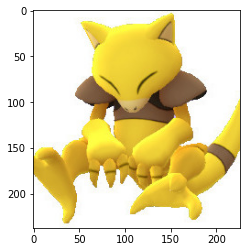

In [8]:
img = Image.open(data_dir + '/Abra/2eb2a528f9a247358452b3c740df69a0.jpg')
plt.imshow(img)

# Load Data

In [9]:
def load_images(data_dir):
    pokemon_img_paths = []
    pokemon_labels = []
    for pokemon_name in os.listdir(data_dir):
        pokemon_img_dir = os.path.join(data_dir, pokemon_name) 
        if not os.path.isdir(pokemon_img_dir):
            continue
            
        for img_filename in os.listdir(pokemon_img_dir):
            if not (img_filename.endswith(".jpg") or img_filename.endswith(".jpeg") or img_filename.endswith(".png")):
                continue
                
            img_path = os.path.join(pokemon_img_dir, img_filename) 
            pokemon_img_paths.append(img_path)
            pokemon_labels.append(pokemon_name)
    
    
    label_name_mapping = list(set(pokemon_labels))
    name_label_mapping = {name: i for i, name in enumerate(label_name_mapping)}
    
    pokemon_labels = [name_label_mapping[name] for name in pokemon_labels]
    
    return np.array(pokemon_img_paths), np.array(pokemon_labels), name_label_mapping, label_name_mapping

In [10]:
img_paths, labels, name_label_mapping, label_name_mapping = load_images(data_dir)

In [11]:
img_paths[30], labels[30], label_name_mapping[labels[30]]

('./PokemonData/Zapdos/1f8b1e9698ab4b77a447368c3239a895.jpg', 1, 'Zapdos')

In [12]:
"Dataset has {} Pokémon".format(len(label_name_mapping))

'Dataset has 150 Pokémon'

In [13]:
img_paths[0]

'./PokemonData/Zapdos/c3f34230c7e24d18845c4d2eaad54801.jpg'

# Train Test Split

Split the images into a training dataset and validation dataset. The training set is used for (yes you guessed it) training the model. The validation set is a separate set of images that is used to check how well our model can generalize to unseen images and identify potential [overfitting](https://www.ibm.com/cloud/learn/overfitting).

In [14]:
TRAIN_TEST_SPLIT = .8

In [15]:
rs = np.random.RandomState(SEED)

In [16]:
def train_test_split(imgs, labels, split_ratio=.8):
    indices = np.arange(len(imgs))
    rs.shuffle(indices)
    
    split_idx = int(len(indices) * TRAIN_TEST_SPLIT)
    train_indices = indices[:split_idx]
    val_indices = indices[split_idx:]
    
    return [imgs[idx] for idx in train_indices], labels[train_indices], [imgs[idx] for idx in val_indices], labels[val_indices],

In [17]:
X_train, Y_train, X_val, Y_val = train_test_split(img_paths, labels, TRAIN_TEST_SPLIT)

# Create Pytorch Dataset and Dataloaders

Define a dataset class with 3 class methods: `__init__()`, `__len__()`, and `__getitem__()`

`__init__()` is automatically called when the dataset is created. We set important class variables here.

`__len__()` should return the length or size of the dataset. In this case, that is the number of images.

`__getitem__()` is the function called when the dataset is indexed to return the image at index `i` and its corresponding label

[Some more documentation on PyTorch datasets can be found here](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)

In [18]:
class PokemonDataset(Dataset):
    def __init__(self, images, labels, preprocessing=None):
        super().__init__()
        self.images = images
        self.labels = labels
        self.preprocessing = preprocessing
        
    def __len__(self):
        return len(self.images)
        
    def __getitem__(self, i):
        img_rgb = Image.open(self.images[i]).convert("RGB")
        if self.preprocessing:
            img_rgb = self.preprocessing(img_rgb)

        return img_rgb, self.labels[i]

## Define image preprocessing

We define two preprocessing pipelines. The training preprocessing pipeline has several randomized image augmentations like random cropping and random flipping to expand the variability in our dataset which helps make the model more robust. 

I initially tried some additional randomized augmentations but realized it really slowed my training down so they're commented out for now. If you're looking for higher performance, these may come in handy.

In [19]:
train_preprocessing = T.Compose([
    T.ToTensor(),
    # T.RandomRotation((-15, 15), expand=False, center=(128, 128)),
    # T.RandomPerspective(distortion_scale=0.3, p=.5),
    # T.RandomResizedCrop(128, scale=(.6, 1.3), ratio=(.8, 1.4), ),
    T.Resize((128, 128)),
    T.RandomHorizontalFlip(),
    # T.ColorJitter(brightness=.2, contrast=.3, saturation=.1, hue=.04),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [20]:
val_preprocessing = T.Compose([
    T.ToTensor(),
    T.Resize((128, 128)),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

## Create Dataset

In [21]:
train_ds = PokemonDataset(X_train, Y_train, train_preprocessing)
val_ds = PokemonDataset(X_val, Y_val, val_preprocessing)

len(train_ds), len(val_ds)

(5456, 1364)

## Create dataloaders

Dataloaders split the datasets into batches. The number of entries in each batch is determined by our variable `BATCH_SIZE`

In [22]:
BATCH_SIZE = 64

In [23]:
train_dl = DataLoader(train_ds, BATCH_SIZE, shuffle=True)
val_dl = DataLoader(val_ds, BATCH_SIZE, shuffle=True)

In [24]:
len(train_dl), len(val_dl)

(86, 22)

# Model Definition

In [25]:
from torchvision.models import inception_v3

In [26]:
class PokemonClassifier(nn.Module):
    def __init__(self, n_out_classes):
        super().__init__()
        self.inception = inception_v3(pretrained=True, aux_logits=False)
        self.out_layers = nn.Linear(1000, n_out_classes)
    
    def forward(self, imgs):
        logits = self.inception(imgs)
        logits = self.out_layers(logits)
        return logits 


Initialize our model and move it to GPU memory

In [27]:
model = PokemonClassifier(n_out_classes=len(label_name_mapping))

In [28]:
model = model.to(DEVICE)
DEVICE

device(type='cpu')

A quick timing experiment

In [29]:
s = time.time()
X_batch, Y_batch = next(iter(train_dl))
print(time.time() - s)
s = time.time()
X_batch = X_batch.to(DEVICE)
Y_batch = Y_batch.to(DEVICE)
print(time.time() - s)
s = time.time()
logits = model(X_batch)
print(time.time() - s)

0.5322940349578857
0.0002422332763671875
1.831639051437378


# Training

## Define learning rate and number of epochs to train for

The learning rate defines the "speed" of learning for the model. You don't want to learn too slowly, but you can't learn too quickly (higher `LEARNING_RATE`) or else you may not reach an optimal model.

In [37]:
LEARNING_RATE = .001
N_EPOCHS = 25

## Define Loss Function and Optimizers

Define the Cross Entropy Loss function and Adam optimizer used to train our model. We'll use and explain more about these in the next step

In [38]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

## Training Helper functions

Function for performing one epoch (one pass through the entire dataset) of training. Training dataset is split into batches of Pokemon images and the model predicts the Pokemon for each batch. 

The loss is the numerical difference between the predicted Pokemon classes and our actual Pokemon classes.

The optimizer performs backpropogation from the loss function and updates the model weights to minimize the loss. If you're unfamiliar with backpropogation, [you can read about it here](https://towardsdatascience.com/backpropagation-made-easy-e90a4d5ede55).

In [39]:
def train_epoch():
    model.train()
    
    losses = 0
    accuracy = 0
    
    for X_batch, Y_batch in train_dl:
        X_batch = X_batch.to(DEVICE)
        Y_batch = Y_batch.to(DEVICE)
        
        logits = model(X_batch)
        loss = loss_fn(logits, Y_batch)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses += loss.item()
        accuracy += (logits.argmax(dim=1) == Y_batch).sum().item() / logits.shape[0]
        
    return losses / len(train_dl), accuracy / len(train_dl)

Function for evaluating the epoch performance using our validation set

In [33]:
def evaluate():
    model.eval()
    
    losses = 0
    accuracy = 0
    
    for X_batch, Y_batch in val_dl:
        X_batch = X_batch.to(DEVICE)
        Y_batch = Y_batch.to(DEVICE)

        logits = model(X_batch)
        loss = loss_fn(logits, Y_batch)
        
        losses += loss.item()
        accuracy += (logits.argmax(dim=1) == Y_batch).sum().item() / logits.shape[0]
        
    return losses / len(val_dl), accuracy / len(val_dl)

In [34]:
def train():
    print("Training on {}".format(DEVICE))
    for epoch in range(N_EPOCHS):
        s = time.time()
        
        train_loss, train_accuracy = train_epoch()
        val_loss, val_accuracy = evaluate()
        
        print("Epoch {}, Train Loss: {}, Train Accuracy: {}%, Val Loss: {}, Val Accuracy: {}%, Time: {}".format(
            epoch, 
            round(train_loss, 3), 
            round(train_accuracy * 100, 2), 
            round(val_loss, 3), 
            round(val_accuracy * 100, 2), 
            round(time.time() - s, 3)
        ))


In [36]:
train()

Training on cuda
Epoch 0, Train Loss: 4.817, Train Accuracy: 4.85%, Val Loss: 4.349, Val Accuracy: 7.54%, Time: 64.204
Epoch 1, Train Loss: 3.208, Train Accuracy: 25.73%, Val Loss: 6.378, Val Accuracy: 24.72%, Time: 64.334
Epoch 2, Train Loss: 1.967, Train Accuracy: 48.84%, Val Loss: 1.601, Val Accuracy: 57.74%, Time: 64.554
Epoch 3, Train Loss: 1.373, Train Accuracy: 63.3%, Val Loss: 1.48, Val Accuracy: 62.0%, Time: 64.337
Epoch 4, Train Loss: 1.017, Train Accuracy: 72.22%, Val Loss: 1.066, Val Accuracy: 71.99%, Time: 65.464
Epoch 5, Train Loss: 0.747, Train Accuracy: 79.51%, Val Loss: 1.115, Val Accuracy: 72.6%, Time: 64.342
Epoch 6, Train Loss: 0.571, Train Accuracy: 83.7%, Val Loss: 1.039, Val Accuracy: 74.01%, Time: 64.602
Epoch 7, Train Loss: 0.501, Train Accuracy: 86.39%, Val Loss: 1.103, Val Accuracy: 75.3%, Time: 64.514
Epoch 8, Train Loss: 0.418, Train Accuracy: 88.32%, Val Loss: 1.02, Val Accuracy: 76.42%, Time: 64.116
Epoch 9, Train Loss: 0.423, Train Accuracy: 87.88%, Val 

KeyboardInterrupt: 

# Evaluate on some test images

In [34]:
def test_some_image(model, img_path, preprocessing=None):
    img_rgb = Image.open(img_path).convert("RGB")
    orig_img = img_rgb
    if preprocessing:
        img_rgb = preprocessing(img_rgb)
    
    model.eval()
    logits = model(img_rgb.unsqueeze(0).to(DEVICE))
    Y_pred = logits.argmax(dim=1).item()
    return label_name_mapping[Y_pred]

In [35]:
torch.__version__

'1.7.1'

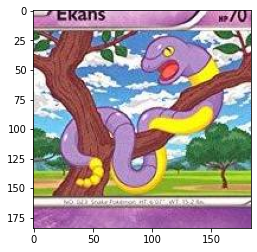

Expected Ekans. Got Muk


In [41]:
test_idx = np.random.randint(len(X_val))
img_path = X_val[test_idx]
img_label = Y_val[test_idx]

plt.imshow(Image.open(img_path).convert("RGB"))
plt.show()

pred = test_some_image(model, img_path, val_preprocessing)
print("Expected {}. Got {}".format(label_name_mapping[img_label], pred))

In [85]:
torch.save(model.state_dict(), "checkpoint.pt")

In [40]:
evaluate()

(31.19865946336226, 0.0007102272727272727)